## Домашнее задание №8

В данном задании вам предстоит детально рассмотреть механизм Attention (и реализовать несколько его вариантов), а также вернуться к задаче классификации текстов из задания №6 и решить ее с использованием BERT.

In [3]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output 
%matplotlib inline

### Шаг №1. Реализация Attention

В данной задаче вам предстоит реализовать механизм Attention, в частности несколько способов подсчета attention scores. Конечно, в популярных фреймворках данный механизм уже реализован, но для лучшего понимания вам предстаит реализовать его с помощью `numpy`.

Ваше задание в данной задаче: реализовать `additive` (аддитивный) и `multiplicative` (мультипликативный) варианты Attention. Для вашего удобства (и для примера) `dot product` attention (основанный на скалярном произведении) уже реализован.

Детальное описание данных типов Attention доступно в лекционных слайдах.

Text(0.5, 1.0, 'Decoder state')

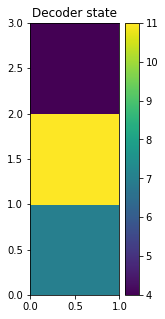

In [ ]:
decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(decoder_hidden_state)
plt.colorbar()
plt.title('Decoder state')

#### Dot product attention (пример реализации)
Рассмотрим единственное состояние энкодера – вектор с размерностью `(n_hidden, 1)`, где `n_hidden = 3`:

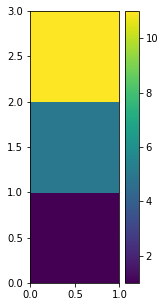

In [ ]:
single_encoder_hidden_state = np.array([1, 5, 11]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(single_encoder_hidden_state)
plt.colorbar()

Attention score между данными состояниями энкодера и декодера вычисляются просто как скалярное произведение:

In [ ]:
np.dot(decoder_hidden_state.T, single_encoder_hidden_state)

array([[106.]])

В общем случае состояний энкодера, конечно, несколько. Attention scores вычисляются с каждым из состояний энкодера:

In [ ]:
encoder_hidden_states = np.array([
    [1, 5, 11],
    [7, 4, 1],
    [8, 12, 2],
    [-9, 0, 1]
    
]).astype(float).T

encoder_hidden_states

array([[ 1.,  7.,  8., -9.],
       [ 5.,  4., 12.,  0.],
       [11.,  1.,  2.,  1.]])

Тогда для подсчета скалярных произведений между единственным состоянием декодера и всеми состояниями энкодера можно воспользоваться следующей функцией (которая по факту представляет собой просто матричное умножение и приведение типов):

In [ ]:
def dot_product_attention_score(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    '''
    attention_scores = np.dot(decoder_hidden_state.T, encoder_hidden_states)
    return attention_scores

In [ ]:
dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)

array([[106.,  97., 196., -59.]])

Для подсчета "весов" нам необходим Softmax:

In [ ]:
def softmax(vector):
    '''
    vector: np.array of shape (n, m)
    
    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    '''
    nice_vector = vector - vector.max()
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1)[:, np.newaxis]
    softmax_ = exp_vector / exp_denominator
    return softmax_

In [ ]:
weights_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))

weights_vector

array([[8.19401262e-040, 1.01122149e-043, 1.00000000e+000,
        1.79848622e-111]])

Наконец, воспользуемся данными весами и вычислим итоговый вектор, как и описано для dot product attention.

[[ 8.]
 [12.]
 [ 2.]]


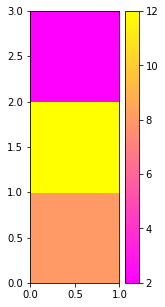

In [ ]:
attention_vector = weights_vector.dot(encoder_hidden_states.T).T
print(attention_vector)

plt.figure(figsize=(2, 5))
plt.pcolormesh(attention_vector, cmap='spring')
plt.colorbar()

Данный вектор аккумулирует в себе информацию из всех состояний энкодера, взвешенную на основе близости к заданному состоянию декодера.

Реализуем все вышеописанные преобразования в единой функции:

In [ ]:
def dot_product_attention(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (n_features, 1)
        Final attention vector
    '''
    softmax_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector

In [ ]:
assert (attention_vector == dot_product_attention(decoder_hidden_state, encoder_hidden_states)).all()

#### Multiplicative attention
Ваша текущая задача: реализовать multiplicative attention.
$$ e_i = \mathbf{s}^TW_{mult}\mathbf{h}_i $$

Матрица весов `W_mult` задана ниже. 
Стоит заметить, что multiplicative attention позволяет работать с состояниями энкодера и декодера различных размерностей, поэтому состояния энкодера будут обновлены:

In [ ]:
import numpy as np

In [ ]:
encoder_hidden_states_complex = np.array([
    [1, 5, 11, 4, -4],
    [7, 4, 1, 2, 2],
    [8, 12, 2, 11, 5],
    [-9, 0, 1, 8, 12]
    
]).astype(float).T

W_mult = np.array([
    [-0.78, -0.97, -1.09, -1.79,  0.24],
    [ 0.04, -0.27, -0.98, -0.49,  0.52],
    [ 1.08,  0.91, -0.99,  2.04, -0.15]
])

In [ ]:
encoder_hidden_states_complex.shape

(5, 4)

In [ ]:
attention_vector = encoder_hidden_states.T @ W_mult
attention_vector

array([[ 11.3 ,   7.69, -16.88,  18.2 ,   1.19],
       [ -4.22,  -6.96, -12.54, -12.45,   3.61],
       [ -3.6 ,  -9.18, -22.46, -16.12,   7.86],
       [  8.1 ,   9.64,   8.82,  18.15,  -2.31]])

In [ ]:
W_1 = np.array([
    [1, 1, 1, 1],
    [ 1, 1, 1, 1],
    [ 1,  1, 1,  1]
])
W_2 = np.array([
    [1, 1, 1, 1, 1],
    [ 1, 1, 1, 1, 1],
    [ 1,  1, 1,  1, 1]
])
W_3 = np.array([
    [1],
    [1],
    [1],
    [1], 
    [1]
])
a = softmax(W_1)
a

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

Реализуйте подсчет attention согласно формулам и реализуйте итоговую функцию `multiplicative_attention`:

In [ ]:
def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_dec, n_features_enc)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    # your code here
    attention_vector = encoder_hidden_states.T @ softmax(W_mult @ decoder_hidden_state)
    return attention_vector

#### Additive attention
Теперь вам предстоит реализовать additive attention.

$$ e_i = \mathbf{v}^T \text{tanh} (W_{add-enc} \mathbf{h}_i + W_{add-dec} \mathbf{s}) $$

Матрицы весов `W_add_enc` и `W_add_dec` доступны ниже, как и вектор весов `v_add`. Для вычисления активации можно воспользоваться `np.tanh`.

In [ ]:
v_add = np.array([[-0.35, -0.58,  0.07,  1.39, -0.79, -1.78, -0.35]]).T

W_add_enc = np.array([
    [-1.34, -0.1 , -0.38,  0.12, -0.34],
    [-1.  ,  1.28,  0.49, -0.41, -0.32],
    [-0.39, -1.38,  1.26,  1.21,  0.15],
    [-0.18,  0.04,  1.36, -1.18, -0.53],
    [-0.23,  0.96,  1.02,  0.39, -1.26],
    [-1.27,  0.89, -0.85, -0.01, -1.19],
    [ 0.46, -0.12, -0.86, -0.93, -0.4 ]
])

W_add_dec = np.array([
    [-1.62, -0.02, -0.39],
    [ 0.43,  0.61, -0.23],
    [-1.5 , -0.43, -0.91],
    [-0.14,  0.03,  0.05],
    [ 0.85,  0.51,  0.63],
    [ 0.39, -0.42,  1.34],
    [-0.47, -0.31, -1.34]
])

In [ ]:
# your code here

Реализуйте подсчет attention согласно формулам и реализуйте итоговую функцию `additive_attention`:

In [ ]:
def additive_attention(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    v_add: np.array of shape (n_features_int, 1)
    W_add_enc: np.array of shape (n_features_int, n_features_enc)
    W_add_dec: np.array of shape (n_features_int, n_features_dec)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    import numpy as np
    attention_vector = v_add.T @ np.tanh (softmax(W_add_enc @ encoder_hidden_states) + softmax(W_add_dec @ decoder_hidden_state))
    return attention_vector

Сдайте функции `multiplicative_attention` и `additive_attention` в контест.

Не забудьте про импорт `numpy`!

### Шаг №2 (опциональный). Классификация текстов с использованием предобученной языковой модели.

Вновь вернемся к набору данных SST-2. Разобьем выборку на train и test аналогично заданию №6.

In [1]:
# do not change the code in the block below
# __________start of block__________

!wget https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw08_attention/holdout_texts08.npy
# __________end of block__________

--2022-12-12 11:38:57--  https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw08_attention/holdout_texts08.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45416 (44K) [application/octet-stream]
Saving to: ‘holdout_texts08.npy’

holdout_texts08.npy 100%[===================>]  44.35K  --.-KB/s    in 0s      

2022-12-12 11:38:58 (97.9 MB/s) - ‘holdout_texts08.npy’ saved [45416/45416]



In [4]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]
texts_holdout = np.load('holdout_texts08.npy', allow_pickle=True)
# __________end of block__________

In [5]:
dat = df[:5000]
det = df[5000:]

In [29]:
texts_train.shape

(5000,)

In [30]:
y_train.shape

(5000,)

Весь остальной код предстоит написать вам.

Для успешной сдачи на максимальный балл необходимо добиться хотя бы __84.5% accuracy на тестовой части выборки__.

In [ ]:
# your beautiful experiments here

In [8]:
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 27.3 MB/s 
     |████████████████████████████████| 132 kB 76.8 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 10.2 MB 67.6 MB/s 
     |████████████████████████████████| 140 kB 79.0 MB/s 
     |████████████████████████████████| 127 kB 80.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 25.3 MB/s 
     |████████████████████████████████| 7.6 MB 70.1 MB/s 
     |████████████████████████████████| 182 kB 78.2 MB/s 


In [10]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb # pytorch-transformers by huggingface
import warnings
import time
warnings.filterwarnings('ignore')

In [11]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [12]:
print(time.ctime())

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

print(time.ctime())

Mon Dec 12 11:39:50 2022


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Mon Dec 12 11:40:10 2022


In [13]:
print(time.ctime())
tokenized_train = dat[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(time.ctime())

Mon Dec 12 11:40:10 2022
Mon Dec 12 11:40:16 2022


In [14]:
tokenized_train .shape

(5000,)

In [15]:
print(time.ctime())
tokenized_test = det[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(time.ctime())

Mon Dec 12 11:40:16 2022
Mon Dec 12 11:40:18 2022


In [16]:
tokenized_test .shape

(1920,)

In [17]:
print(time.ctime())

max_len = 0
for i in tokenized_train.values:
    if len(i) > max_len:
        max_len = len(i)

padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])

print(time.ctime())

Mon Dec 12 11:40:18 2022
Mon Dec 12 11:40:18 2022


In [18]:
np.array(padded_train).shape

(5000, 67)

In [19]:
print(time.ctime())

max_len = 0
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)

padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])

print(time.ctime())

Mon Dec 12 11:40:18 2022
Mon Dec 12 11:40:18 2022


In [20]:
np.array(padded_test).shape

(1920, 64)

In [21]:
padded_test

array([[  101,  2019, 17727, ...,     0,     0,     0],
       [  101,  2023,  2613, ...,     0,     0,     0],
       [  101,  3403,  2005, ...,     0,     0,     0],
       ...,
       [  101,  1996,  5896, ...,     0,     0,     0],
       [  101,  1037,  5667, ...,     0,     0,     0],
       [  101,  1037, 12090, ...,     0,     0,     0]])

In [22]:
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_train.shape

(5000, 67)

In [23]:
attention_mask_test = np.where(padded_test != 0, 1, 0)
attention_mask_test.shape

(1920, 64)

In [24]:
input_ids = torch.tensor(padded_train)  
attention_mask = torch.tensor(attention_mask_train)

with torch.no_grad():
    last_hidden_states_train = model(input_ids, attention_mask=attention_mask)

In [25]:
input_ids = torch.tensor(padded_test)  
attention_mask = torch.tensor(attention_mask_test)

with torch.no_grad():
    last_hidden_states_test = model(input_ids, attention_mask=attention_mask)

In [26]:
features_train = last_hidden_states_train[0][:,0,:].numpy()

In [28]:
features_train.shape

(5000, 768)

In [31]:
features_test = last_hidden_states_test[0][:,0,:].numpy()

In [32]:
features_test.shape

(1920, 768)

In [33]:
lr_clf = LogisticRegression()
lr_clf.fit(features_train, y_train)

LogisticRegression()

In [34]:
lr_clf.score(features_test, y_test)

0.8484375

In [37]:
prob_train = lr_clf.predict_proba(features_train)
prob_test = lr_clf.predict_proba(features_test)

In [39]:
prob_train.shape

(5000, 2)

In [52]:
hold = pd.DataFrame(texts_holdout)
hold

,0
0,"gee , a second assassin shot kennedy ?"
1,from the big giant titles of the opening credi...
2,"the movie is well shot and very tragic , and o..."
3,the movie quickly drags on becoming boring and...
4,a mixed bag of a comedy that ca n't really be ...
...,...
495,an unsatisfying hybrid of blair witch and typi...
496,"a real movie , about real people , that gives ..."
497,eight crazy nights is a showcase for sandler '...
498,all i can say is fuhgeddaboutit


In [53]:
print(time.ctime())
tokenized_holdout = hold[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(time.ctime())

Mon Dec 12 12:09:13 2022
Mon Dec 12 12:09:13 2022


In [55]:
print(time.ctime())

max_len = 0
for i in tokenized_holdout.values:
    if len(i) > max_len:
        max_len = len(i)

padded_holdout = np.array([i + [0]*(max_len-len(i)) for i in tokenized_holdout.values])

print(time.ctime())

Mon Dec 12 12:10:32 2022
Mon Dec 12 12:10:32 2022


In [56]:
attention_mask_hold = np.where(padded_holdout != 0, 1, 0)
attention_mask_hold.shape

(500, 57)

In [57]:
input_ids = torch.tensor(padded_holdout)  
attention_mask = torch.tensor(attention_mask_hold)

with torch.no_grad():
    last_hidden_states_hold = model(input_ids, attention_mask=attention_mask)

In [58]:
features_hold = last_hidden_states_hold[0][:,0,:].numpy()

In [59]:
prob_hold = lr_clf.predict_proba(features_hold)

#### Сдача взадания в контест
Сохраните в словарь `out_dict` вероятности принадлежности к нулевому и первому классу соответственно:

In [60]:
out_dict = {
    'train':prob_train, # np.array of size (5000, 2) with probas
    'test': prob_test, # np.array of size (1920, 2) with probas
    'holdout':prob_hold # np.array of size (500, 2) with probas
}

Несколько `assert`'ов для проверки вашей посылки:

In [61]:
assert isinstance(out_dict['train'], np.ndarray), 'Dict values should be numpy arrays'
assert out_dict['train'].shape == (5000, 2), 'The predicted probas shape does not match the train set size'
assert np.allclose(out_dict['train'].sum(axis=1), 1.), 'Probas do not sum up to 1 for some of the objects'

assert isinstance(out_dict['test'], np.ndarray), 'Dict values should be numpy arrays'
assert out_dict['test'].shape == (1920, 2), 'The predicted probas shape does not match the test set size'
assert np.allclose(out_dict['test'].sum(axis=1), 1.), 'Probas do not sum up to 1 for some of the object'

assert isinstance(out_dict['holdout'], np.ndarray), 'Dict values should be numpy arrays'
assert out_dict['holdout'].shape == (500, 2), 'The predicted probas shape does not match the holdout set size'
assert np.allclose(out_dict['holdout'].sum(axis=1), 1.), 'Probas do not sum up to 1 for some of the object'

Запустите код ниже для генерации посылки и сдайте файл `submission_dict_hw08.npy`.

In [62]:
# do not change the code in the block below
# __________start of block__________

np.save('submission_dict_hw08.npy', out_dict, allow_pickle=True)
print('File saved to `submission_dict_hw08.npy`')
# __________end of block__________

File saved to `submission_dict_hw08.npy`


На этом задание завершено. Поздравляем!